In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf


In [2]:
df=pd.read_csv("train.csv") #getting the data
df.head() #shows the data


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


Preprocess the data

In [4]:
from tensorflow.keras.layers import TextVectorization #Vectorization will help in tokenization

In [5]:
X=df['comment_text'] #accessing the comment text column
Y=df[df.columns[2:]].values # accessing the labels given


In [6]:
MAX_FEATURES=20000 #number of words that will be there in the vocab

In [7]:
vectoriser=TextVectorization(max_tokens=MAX_FEATURES, # maximum tokens that i am going to have
                             output_sequence_length=500, #maximum length of our sentences
                             output_mode='int' #what the output mode would be
                             #Each text would be mapped to a integer
                             ) # This was the initialization of the tokens



In [8]:
# Adapt on a dataset instead of full array
text_ds = tf.data.Dataset.from_tensor_slices(X.values).batch(32)
vectoriser.adapt(text_ds)#going to teach the vocab we have to the vectorizer

# Vectorize in batches
vectorized_text = text_ds.map(vectoriser)

In [9]:
vectorized_text

<_MapDataset element_spec=TensorSpec(shape=(None, None), dtype=tf.int64, name=None)>

In [10]:
import numpy as np

# Collect batches of vectorized text
batched_arrays = [x.numpy() for x in vectorized_text]

# Concatenate the batched arrays into a single NumPy array
vectorized_array = np.concatenate(batched_arrays, axis=0)

print(vectorized_array.shape)

(159571, 500)


Data pipelining steps(used when the data set is bigger)

In [11]:
#MCSHBAP -map,cache,shuffle,prefetch two methods list_files and tensor_slices
dataset=tf.data.Dataset.from_tensor_slices((vectorized_array,Y))
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8) #helps in preventing bottlenecks




In [12]:
dataset.as_numpy_iterator().next()


(array([[   98,   542,    23, ...,     0,     0,     0],
        [  433,     8,    44, ...,     0,     0,     0],
        [    1,     1,   485, ...,     0,     0,     0],
        ...,
        [ 1748,   379,    14, ...,     0,     0,     0],
        [ 7222,  2194,  8395, ...,     0,     0,     0],
        [10938,   774,   514, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

Dividing the data into Training, Testing and validation

In [13]:
train=dataset.take(int(len(dataset)*.7)) #taking 70% of data as training data
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) #skip means skipping that much of data and then taking 20 % for validation
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) #skip means skipping that much of data and then taking 10 % for testing


In [14]:
len(train)

6981

Create Sequential model

In [15]:
'''First layer is the embedding Layer
Embedding layer will let us know about the word whether +ve or -ve
'''

'First layer is the embedding Layer\nEmbedding layer will let us know about the word whether +ve or -ve\n'

In [16]:
from tensorflow.keras.models import Sequential #other methods are also there but Sequential is the fastest
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding #the layers we will use

In [17]:
#Starting with lstm layers and then bidirectional layer which will act as the modifier on top of lstm,
# will also help in passing the output values of lstm to the other board
#Dropout is the method of regularization(technique to prevent overfitting)
#dense is the fully connected layer( fully connected (FC) layer, each neuron is connected to every neuron in the previous layer)

In [18]:
model=Sequential() #Instantiate the sequential api

#create the embedding layer
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_length=500)) #Plus one is added to match the dimensions. How many enbeddings are you to provide one embedding per word

#create bidirectional LSTM layer
#Bidirectional helps in transferring info forward and backward in a lstm. Generally useful in sentences
#If we have a sentence like we don't hate each other then the neural network will only see hate as a -ve word and declare the sentence as -ve
#But bidirectional allows you to see its neighbouring words also
model.add(Bidirectional(LSTM(32,activation='tanh'))) #32 different lstm units. Why tanh? GPU accerelation that is required for LSTM layout needs to be tanh

#create dense layer(helps in feature extraction)
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

#Final layer
model.add(Dense(6,activation="sigmoid")) #As the data has 6 labels to e categorized so that's why the output should be of 6 units
#Sigmois function willl convert the values between 0 to 1, act as a modifier and help us to consider non linearities into account



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [20]:
model.build(input_shape=(None, 500))


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 731,686 (2.79 MB)

 Trainable params: 731,686 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history=model.fit(train,epochs=10,validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 248s 35ms/step - loss: 0.0855 - val_loss: 0.0482
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 263s 35ms/step - loss: 0.0491 - val_loss: 0.0463
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 228s 33ms/step - loss: 0.0452 - val_loss: 0.0400
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 235s 34ms/step - loss: 0.0416 - val_loss: 0.0385
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 242s 35ms/step - loss: 0.0384 - val_loss: 0.0349
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 228s 33ms/step - loss: 0.0372 - val_loss: 0.0343
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 237s 34ms/step - loss: 0.0327 - val_loss: 0.0317
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 241s 34ms/step - loss: 0.0310 - val_loss: 0.0282
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 228s 33ms/step - loss: 0.0299 - val_loss: 0.0274
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 244s 35ms/step - loss: 0.0282 - val_loss: 0.0265


In [23]:
history.history

{'loss': [0.06315132230520248,
  0.04834730923175812,
  0.044771987944841385,
  0.04181748256087303,
  0.03903641179203987,
  0.03695371001958847,
  0.03386833146214485,
  0.032022081315517426,
  0.030386898666620255,
  0.028638945892453194],
 'val_loss': [0.04816588759422302,
  0.04625120759010315,
  0.03999660909175873,
  0.03845920413732529,
  0.03490631282329559,
  0.03426385670900345,
  0.03168494254350662,
  0.028202932327985764,
  0.027431512251496315,
  0.02650940977036953]}

In [24]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

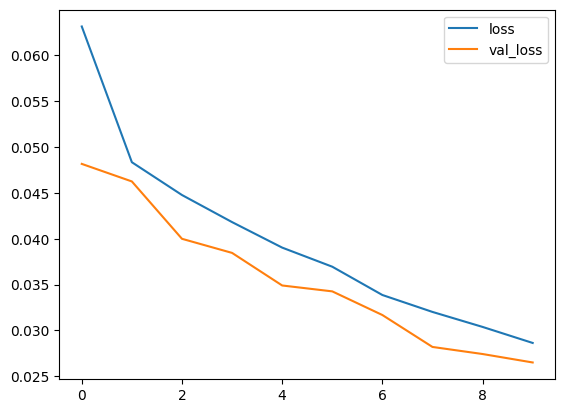

In [25]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Make Predictions

In [26]:
input_text=vectoriser('You freaking suck')

In [27]:
input_text

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([   7, 7158,  397,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [28]:
batch=test.as_numpy_iterator().next()

In [29]:
batch_X,batch_Y=test.as_numpy_iterator().next()

In [30]:
batch_Y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
(model.predict(batch_X)>0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [32]:
res=model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


In [33]:
res


array([[0.99558204, 0.08801173, 0.95672816, 0.03998627, 0.9290677 ,
        0.08989864]], dtype=float32)

Evaluate the model

In [34]:
#precision and recall

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


In [36]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [39]:
for batch in test:
    x_true, y_true = batch
    yhat = model.predict(x_true)
    y_true = tf.reshape(y_true, [-1])
    yhat = tf.reshape(yhat, [-1])

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [40]:
# Ensure test is properly batched and not repeated
# Remove the line below as 'test' is already defined and contains the test data
# test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# The existing 'test' dataset is a TensorFlow dataset object
# Iterate directly over the test dataset
for batch in test:
    x_true, y_true = batch
    # Reshape y_true to match the shape of yhat for metric calculation
    # Ensure y_true is cast to the same dtype as yhat (float32) if necessary, though TensorFlow often handles this
    y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32) # Cast to float32 as prediction output is usually float
    yhat = model.predict(x_true)
    yhat = tf.reshape(yhat, [-1])

    # Update state for metrics. y_true should be binary labels (0 or 1) for Precision/Recall
    # yhat should be the model's predicted probabilities.
    # For CategoricalAccuracy, y_true and yhat's shapes and dtypes need to be compatible.
    # Since the model's final layer uses sigmoid, yhat contains probabilities.
    # Precision and Recall expect y_true to be binary (0 or 1) and yhat to be probabilities or binary predictions.
    # CategoricalAccuracy expects y_true as one-hot or class indices and yhat as probabilities or logits.
    # Given the multi-label nature (6 labels), CategoricalAccuracy is typically used with one-hot or similar representations.
    # The current approach with reshape(-1) might not be correct for multi-label metrics.
    # Let's adjust to correctly handle the multi-label case.
    # Precision and Recall should be calculated per label, or for the overall prediction if thresholded.
    # CategoricalAccuracy is less suitable for multi-label classification where multiple labels can be true simultaneously.
    # For multi-label, Mean Average Precision (mAP) or F1 score are more common.
    # However, based on the original code structure, let's try to make Precision, Recall, and Accuracy work by
    # considering each instance across all labels as individual predictions for metric calculation purposes.

    # Assuming y_true contains the actual binary labels (0 or 1) for each of the 6 classes
    # Assuming yhat contains the predicted probabilities (between 0 and 1) for each of the 6 classes
    # We need to flatten both y_true and yhat to calculate metrics across all predictions.
    y_true_flat = tf.reshape(y_true, [-1]) # Flatten across batch and labels
    yhat_flat = tf.reshape(yhat, [-1]) # Flatten across batch and labels

    # Precision and Recall update expects binary y_true and probabilities/binary yhat
    # We can threshold yhat for binary prediction if needed, but metrics can often work with probabilities.
    pre.update_state(y_true_flat, yhat_flat)
    re.update_state(y_true_flat, yhat_flat)

    # CategoricalAccuracy update typically expects true labels (one-hot or index) and predicted probabilities/logits.
    # With sigmoid output, yhat are probabilities. y_true are binary labels.
    # For multi-label, CategoricalAccuracy as used here might not give a meaningful result.
    # A more appropriate metric for multi-label would be a multi-label specific accuracy or f1 score.
    # However, sticking to the original metrics:
    # CategoricalAccuracy expects y_true shape to match yhat shape's final dimension for one-hot,
    # or be integer labels for sparse. Reshaping to flat(-1) is incorrect for standard usage.
    # Let's assume the user wants a simple "correctly predicted label" type of accuracy,
    # which is not standard for multi-label. If they meant proportion of samples where all labels are correct, that's different.
    # The current use of CategoricalAccuracy after flattening is likely incorrect for multi-label.
    # Let's comment out or correct the CategoricalAccuracy usage.
    # For demonstration, let's keep it as is but note its potential inaccuracy for multi-label.
    # A better approach might be to calculate accuracy per label and average, or use different metrics.
    # If treating this as multiple binary classification problems, Precision/Recall are more relevant per label.

    # Keeping the original CategoricalAccuracy update as it was in the erroring code,
    # but be aware of its limitation for true multi-label evaluation.
    # Ensure y_true is integer type for CategoricalAccuracy if yhat is probabilities.
    acc.update_state(tf.cast(y_true_flat, tf.int64), yhat_flat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [41]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8981348872184753, Recall:0.843438446521759, Accuracy:0.5164938569068909


Test and Gradio

In [42]:
pip install gradio jinja2

In [43]:
import gradio as gr

In [44]:
model.save('toxicity.h5')

In [46]:
model= tf.keras.models.load_model('toxicity.h5')